In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio

In [2]:
def plot_spectrogram(y):
    y_mono = librosa.to_mono(y)  
    D = librosa.stft(y_mono)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    plt.figure(figsize=(10, 6))
    librosa.display.specshow(D_db, sr=22070, x_axis='time', y_axis='log') # use native sampling rate
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

In [15]:
from scipy.signal import butter, sosfilt
import numpy as np

def apply_filter(audio_signal, sr, filter_type, cutoff_freq, slope=2, gain=0):
    """
    Apply low-pass, high-pass, notch, or high-shelf filter to an audio signal.
    
    Parameters:
    - audio_signal (np.ndarray): Input audio signal.
    - sr (int): Sampling rate of the audio signal.
    - filter_type (str): Type of filter ('lowpass', 'highpass', 'notch', 'highshelf').
    - cutoff_freq (float or tuple): Cutoff frequency/frequencies in Hz.
                                    For 'notch', provide as (low, high).
                                    For 'highshelf', this is the corner frequency.
    - slope (int): Slope of the filter (order of Butterworth filter, or Q factor for 'highshelf').
    - gain (float): Gain in dB for the high-shelf filter (default is 0 for no gain).
    
    Returns:
    - filtered_signal (np.ndarray): Filtered audio signal.
    
    Raises:
    - ValueError: If the cutoff frequency is out of bounds.
    """
    # Nyquist frequency
    nyquist = sr / 2.0
    
    # Validate cutoff frequencies
    if filter_type in ["lowpass", "highpass", "highshelf"]:
        if not (0 < cutoff_freq < nyquist):
            raise ValueError(
                f"Cutoff frequency for {filter_type} filter must be between 0 and {nyquist:.2f} Hz. "
                f"Provided: {cutoff_freq} Hz."
            )
    elif filter_type == "notch":
        if not isinstance(cutoff_freq, tuple) or len(cutoff_freq) != 2:
            raise ValueError("For a notch filter, provide cutoff_freq as a tuple (low, high).")
        if not (0 < cutoff_freq[0] < cutoff_freq[1] < nyquist):
            raise ValueError(
                f"Cutoff frequencies for notch filter must be between 0 and {nyquist:.2f} Hz. "
                f"Provided: {cutoff_freq} Hz."
            )
    else:
        raise ValueError("Invalid filter type. Choose from 'lowpass', 'highpass', 'notch', or 'highshelf'.")
    
    # Design the filter
    if filter_type == "lowpass":
        sos = butter(slope, cutoff_freq / nyquist, btype="low", output="sos")
    elif filter_type == "highpass":
        sos = butter(slope, cutoff_freq / nyquist, btype="high", output="sos")
    elif filter_type == "notch":
        sos = butter(slope, [cutoff_freq[0] / nyquist, cutoff_freq[1] / nyquist], btype="bandstop", output="sos")
    elif filter_type == "highshelf":
        # Convert gain to linear scale
        gain_linear = 10 ** (gain / 20.0)
        
        # Design high-shelf filter coefficients using biquad formula
        omega = 2 * np.pi * cutoff_freq / sr
        alpha = np.sin(omega) / (2 * slope)
        A = gain_linear
        
        b0 = A * ((A + 1) + (A - 1) * np.cos(omega) + 2 * np.sqrt(A) * alpha)
        b1 = -2 * A * ((A - 1) + (A + 1) * np.cos(omega))
        b2 = A * ((A + 1) + (A - 1) * np.cos(omega) - 2 * np.sqrt(A) * alpha)
        a0 = (A + 1) - (A - 1) * np.cos(omega) + 2 * np.sqrt(A) * alpha
        a1 = 2 * ((A - 1) - (A + 1) * np.cos(omega))
        a2 = (A + 1) - (A - 1) * np.cos(omega) - 2 * np.sqrt(A) * alpha
        
        # Normalize coefficients
        b = np.array([b0, b1, b2]) / a0
        a = np.array([a0, a1, a2]) / a0
        
        # Convert to SOS format for stability
        sos = np.array([[b[0], b[1], b[2], 1, a[1], a[2]]])
    
    # Apply the filter
    filtered_signal = sosfilt(sos, audio_signal)
    return filtered_signal


In [4]:
# audio_path = librosa.example('trumpet')
audio_path = '/home/anuj/Kabir/ASR/medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/test/1249120_1853182_11719913.wav'

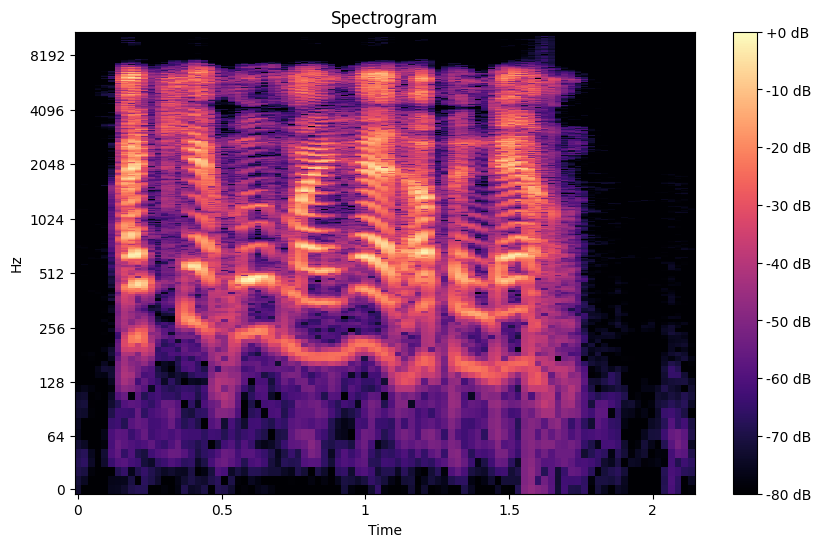

In [44]:
y, sr = librosa.load(audio_path, sr=22050, mono=False)
y = librosa.to_mono(y)
plot_spectrogram(y)

In [45]:
Audio(data=y, rate=sr)

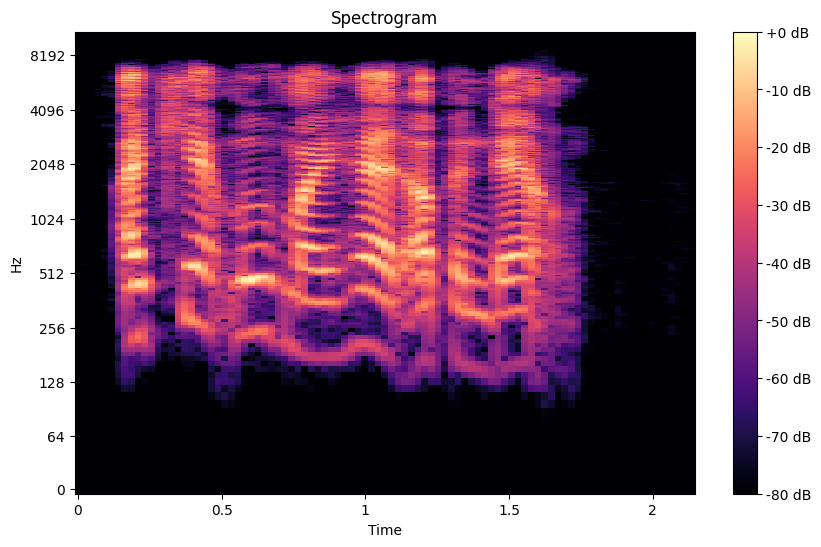

In [51]:
y_high = apply_filter(y, sr, filter_type="highpass", cutoff_freq=250, slope=4,gain=0)
y_low = apply_filter(y_high, sr, filter_type="lowpass", cutoff_freq=8000, slope=4, gain=0)
plot_spectrogram(y_low)

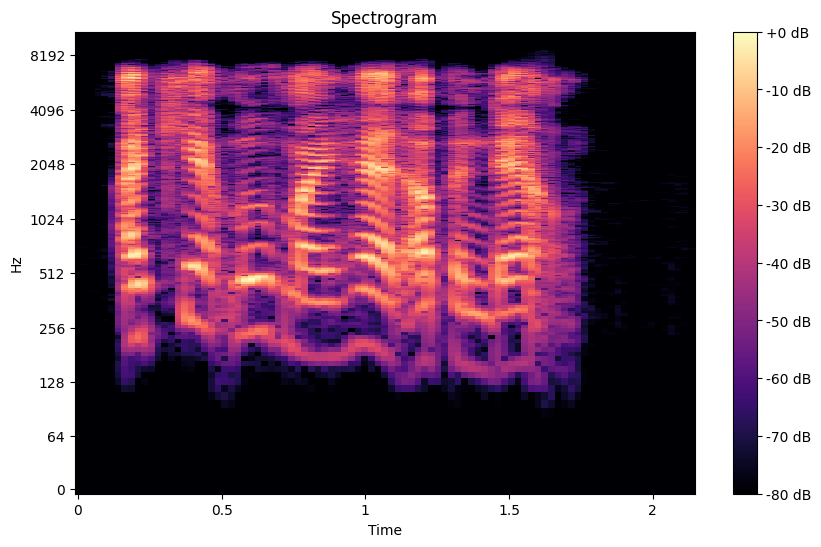

In [52]:
y_mono_cleaned = apply_filter(y_low,sr,filter_type='highshelf',cutoff_freq=3000, slope=2,gain=3)
y_mono_enhanced = apply_filter(y_low,sr,filter_type='highshelf',cutoff_freq=6000, slope=1,gain=1)
plot_spectrogram(y_mono_enhanced)

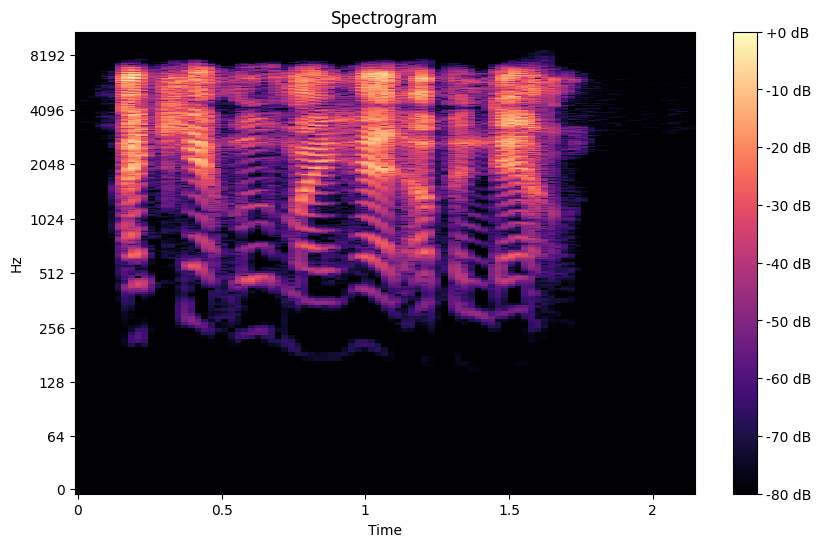

In [53]:
plot_spectrogram(y_mono_cleaned-y_low) # added difference

In [54]:
Audio(data=y_mono_cleaned, rate=sr)